## Phase interference in Quantum Random Walk

Some drawings in this work are adopted from below github:
- J. Kemp, S. Nishio, R. Satoh, D. Vogt-Lee, and T. Bassan, [Implementation of Quantum Walks on Cycle Graph](https://github.com/desireevl/quantum_walk)

## Contributors
This work represents the collective efforts done by below group members:
- I-Tung Chen (U. Of Washington, US)
- Ran-Yu Chang (CCHS, Taiwan)
- Yu-Chao HSU (CCHS, Taiwan)
- Yu-Chen Hung (CGSH, Taiwan)
- Wen-Sen Lu (Rutgers U., US)

# Introduction

## What is random walk 

A random walk, as being quoted here from [wikipedia](https://en.wikipedia.org/wiki/Random_walk),
> describes a path that consists of a succession of random steps on some mathematical space such as the integers.

In this work, we explorer the dynamics of phase interferences when implementing the discrete quantum random walk in Qiskit QASM simulators.

A random walk can be computationally realized by iterating the following algorithm:
1. A walker is located at certain point n in the N-dimensional space (in this work N=1 and the walker walks along a line, starting from point n as shown in the below picture)
2. A random number is generated with equal probability to decide which direction the walker will walk into. (the "coin")
3. The walker perform nearest-neighbor jump to either point (n-1) or (n+1) based on the random number generated in step 2 (say, 1/0 or head/tail).

This process is iterated and the dynamic is studied in classical search algorithm and has wide applications for example binary tree searches. As a brother of Grover search algorithm, the quantum random walk problem also demonstrates quantum advantage when compared to its classical counterpart [[ref 1]](https://fangsong.info/teaching/s17_4510_qc/proj_AI_QW.pdf).

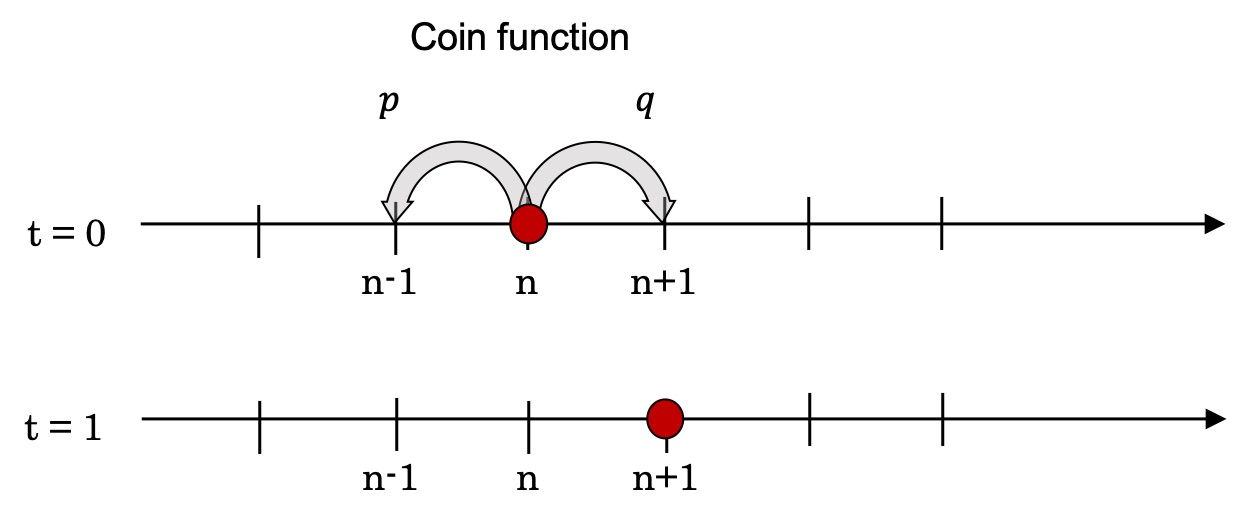

In [3]:
import os
import os.path
from IPython.display import display
from PIL import Image
display(Image.open( "./images/random_walk.jpg"))

## Quantum Walk 

In classical computer, the random number was generated from a pre-calculated list. In quantum computer, the random number can be generated by harvesting inherent randomness from quantum mechanics. Such generation is referred as the "coin operator" and is usually done with the Hadamard gate (for example [[ref 2]](https://github.com/desireevl/quantum_walk)),

$$H=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & 1 \\ 1 & -1\\ \end{array}}\right]$$

However, many different coin operators exist as long as the requirement is met when walking in either directions are equally probable. 

One distinct feature in quantum random walk to its classical counterpart is that this coin register will continue interfere with its position state until it is measured, after all intermediate steps. The results are very different from classical random walks as it doesn’t converge to a Gaussian distribution, but rather evolves into an asymmetric probability distribution as we show below

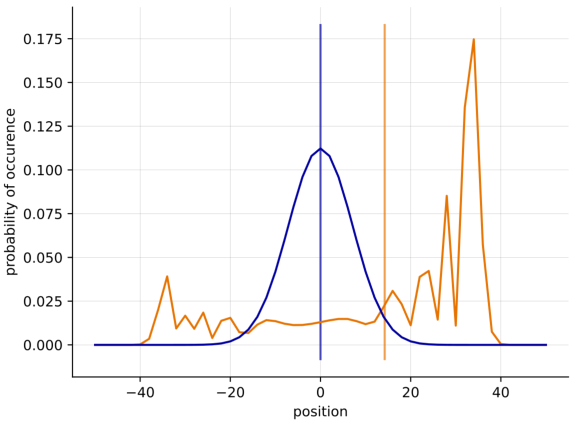

In [8]:
display(Image.open('./images/CvQ.png'))

The deviation from a Gaussian has been extensively discussed in [ref 3](https://vixra.org/pdf/1909.0131v1.pdf), and such distribution was used to optimize binary tree search algorithm in certain cases as well [[ref 4]](https://arxiv.org/pdf/quant-ph/0210064.pdf).

## The phase interference

In addition to the deviation from Gaussian, in this work we focus more on the asymmetric distribution in the quantum random walk where we see in above graph. As indicated in [ref 3](https://vixra.org/pdf/1909.0131v1.pdf), such asymmetry arises because the Hadamard coin operator treats each basis vectors, |↑> and |↓> , differently by observing the phase difference.

In the Hadamard coin operator, the rightwards path interferes more destructively as it is multiplied by -1, however, the leftwards path undergoes more constructive interference and the system tends to take steps towards the left. To reach symmetric results, both base vectors will start in a superposition of states (between  |↑> and |↓>). Another way to reach symmetry is use a different coin operator which doesn’t bias the coin towards a certain base vector, such as the gate with matrix representation shown below:

$$Y=\frac{1}{\sqrt{2}}\left [{\begin{array}{rr}1 & i \\ i & 1\\ \end{array}}\right]$$

The entire effect is similar to the idea of phase kickback [[ref 5]](https://qiskit.org/textbook/ch-gates/phase-kickback.html)

The circuit representation of this Y circuit seems to be straightforward, but as we will show in this work some other careful treatment (in addition to converting H to Y) should be done to fully employ the symmetric treatment in terms of phase on the Bloch sphere. 

This constitutes out motivation to use Qiskit to study interference effects in the phase of a quantum circuit. 

# Implementation

Here we break down the quantum walk algorithm. Below shows two successive walks when Hadamard gate was used as the coin operator.

The operations propagate systemically around the graph as each node is a seperate bit-string value in lexicographic order. For a 2n graph, n qubits are required to encode the problem and 1 ancilla qubit is required to prepare the coin stat.

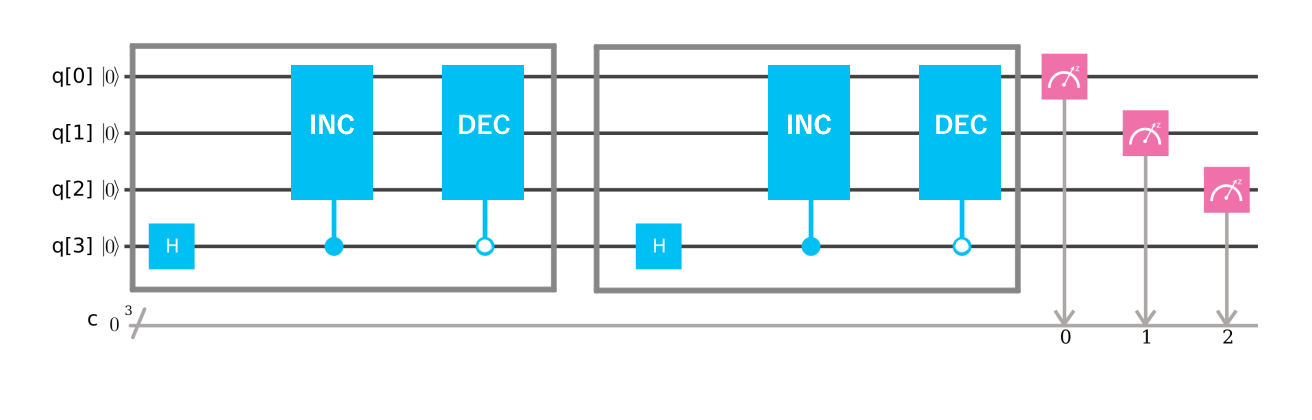

In [20]:
display(Image.open("./images/whole_circuit.jpg"))

The above circuit shows the whole process of the quantum walk on a cycle graph with $2^3$ nodes. 

The gray rectangular frame outlines a set of coin operators and shift operators. 

In this circuit, q[0] to q[2] represent the state (position) of quantum walker, and q[3] represents the coin operator.

In this style, a programmer can insert the initial position of walker as a 3-qubit state. For example, if the input is $110$, then the position is $6$ (see the earlier cycle graph). 

The coin operator decides whether the walker proceeds clockwise or counterclockwise.

INC is a gate that increments the state of the walker which is equal to a clockwise rotation in the cycle graph. 

DEC is gate that decrements the state of the walker which is equal to a counterclockwise rotation in cycle graph.

After repeatedly executing the coin operator and the shift operator, we can measure the qubits (excluding the ancilla coin qubit), and it is then possible to know the position of the walker.

The detail of the construction of INC and DEC gate will be illustrated in section 3.

# Results

### Define repeating codes

In [10]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, IBMQ, execute
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt
import imageio,os
%matplotlib inline

Co = 1
Re = 5*Co
steps=20

QrC = QuantumRegister(Co, 'scratch')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

backend = BasicAer.get_backend("qasm_simulator")

C:\Users\racco\AppData\Roaming\Python\Python37\site-packages\qiskit\__init__.py:64: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  RuntimeWarning)


In [11]:
def jobplot(job, ax, color='C0', Re=Re,alpha=1,label=None):
    xlst,ylst = [],[]
    for i in job:
        val = int(i,2)
        if val>=2**(Re-1) :
            xlst += [(val-2**Re+0)*-1-1]
        else:
            xlst += [(val+0)*-1-1]
        ylst +=[job[i]] 
    ax.bar(xlst,ylst,alpha=alpha,color=color,label=label)
    
def jobNorm(job):
    total = 0
    for i in job:
        total += job[i]
    lst = [job[i]/(total) for i in job]

    jod = {}
    for i,v in enumerate(job):
        jod[v] = lst[i]
    return [job, jod]
    
def flipReg():
    qc.cx(QrC[0],QrR[0])
    qc.x(QrR[0])
    qc.ccx(QrC[0],QrR[0],QrR[1])
    qc.x(QrR[1])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.x(QrR[2])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.x(QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.x(QrC[0])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.x(QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.x(QrR[2])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.x(QrR[1])
    qc.ccx(QrC[0],QrR[0],QrR[1])
    qc.x(QrR[0])
    qc.cx(QrC[0],QrR[0])
    
def flipReg1():
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.ccx(QrC[0],QrR[0],QrR[1])
    qc.cx(QrC[0],QrR[0])

    qc.x(QrC[0])
    for i in range(4):
        qc.x(QrR[i])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2],QrR[3]],QrR[4])
#     qc.x(QrR[3])
    qc.mcx([QrC[0],QrR[0],QrR[1],QrR[2]],QrR[3])
#     qc.x(QrR[2])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
#     qc.x(QrR[1])
    qc.ccx(QrC[0],QrR[0],QrR[1])
#     qc.x(QrR[0])
    qc.cx(QrC[0],QrR[0])

### The construction of INC and DEC gate

Here we listed how we construct the INC and DEC gate. The first two circuits shown here are found from [[ref 6]](https://arxiv.org/pdf/0706.0304.pdf).

We would like to point out that the 3rd circuit, which is actually a reverse operation of INC gate, is constructed by utilizing the reversible operation of the quantum computation. We put it here just to showcase the idea of reversible computation gifted by quantum computing.


 increase operator (the quantum counter)


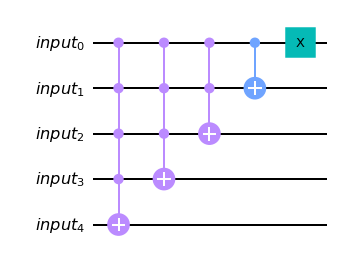

decrease operator: version 1


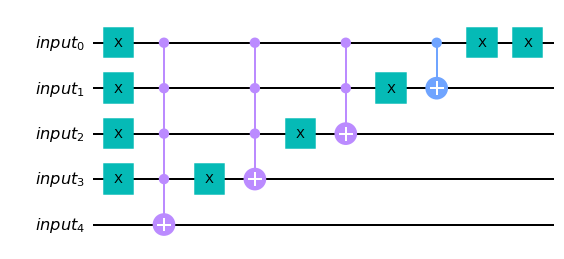

decrease operator: version 2 (reverse counter)


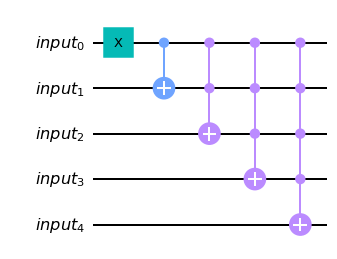

In [17]:
# H-gate -> increase gate (INC) -> decrease gate (DEC)
Co = 1
Re = 5*Co

QrC = QuantumRegister(Co, 'scratch')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

backend = BasicAer.get_backend("qasm_simulator")

print ('\n increase operator (the quantum counter)')
# increase block
inqc = QuantumCircuit(QrR)

for i in range(Re-1):
    inqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
inqc.x(0)
display(inqc.draw('mpl'))

ingate = inqc.to_gate()
cingate = ingate.control(label="increase gate")

print ('decrease operator: version 1')
# decrease block: following paper
deqc = QuantumCircuit(QrR)

deqc.x(QrR[:Re-1])
for i in range(Re-1):
    deqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
    deqc.x(QrR[Re-1-i-1])
deqc.x(QrR[0])

display(deqc.draw('mpl'))

degate = deqc.to_gate()
cdegate = degate.control(label="decrease gate")

print ('decrease operator: version 2 (reverse counter)')
# decrease block2: reversible
deqc2 = QuantumCircuit(QrR)

deqc2.x(0)
for i in range(Re-1,0,-1):
    deqc2.mcx(QrR[:Re-1-(i-1)],QrR[Re-1-(i-1)])

display(deqc2.draw('mpl'))

degate2 = deqc2.to_gate()
cdegate2 = degate2.control(label="decrease gate 2")

## Classical Random Walk

Here we quickly wrote a classical random walk, such that later on we can verify the deviation of quantum random walk from the classical Gaussian-like distribution.

In [12]:
def classicalWalk(ax, steps=20, alpha=1, color='C0', label = None, sample=100):
    relst = []
    for j in range(sample):
        result = 0
        for i in range(steps):
            result+=2*np.random.randint(2)-1
        relst += [result]
    counts, bins=np.histogram(relst)
    ax.hist(bins[:-1], bins, weights=counts/counts.sum(),
            rwidth=0.2, alpha=alpha, label=label, color=color)
    return (relst)

(array([ 1,  3,  0, 13,  0, 13, 14,  0, 20,  0, 10, 14,  0,  5,  0,  4,  2,
         0,  0,  1], dtype=int64),
 array([-10. ,  -8.8,  -7.6,  -6.4,  -5.2,  -4. ,  -2.8,  -1.6,  -0.4,
          0.8,   2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,
         11.6,  12.8,  14. ]))

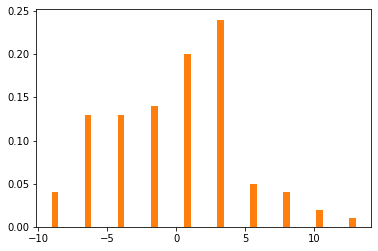

In [13]:
f,ax=plt.subplots()
np.histogram(classicalWalk(ax,color='C1'),bins=steps)

### Run the Hadamard coin for a quantum random walk

This is the Hadamard coin without uncomputing the X gate

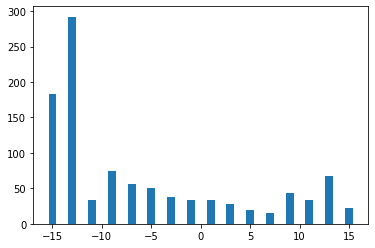

In [18]:
qc = QuantumCircuit(QrC,QrR,Cr)

for i in range(20):
    qc.h(QrC[0])
    flipReg()
#     qc.x(QrC[0])

#     if i==1:
#         display(qc.draw(output='mpl'))

qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
# display(plot_histogram(job))
f,ax=plt.subplots()
jobplot(job,ax)

This is the Hadamard coin with the X gate uncomputed

### Comparing Quantum and Classical walks

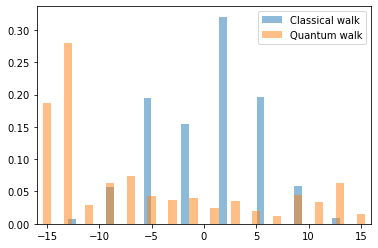

In [19]:
f,ax=plt.subplots()
classicalWalk(ax,steps=22,color='C0',alpha=0.5,label = 'Classical walk',sample=100000)

qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.h(QrC[0])
    flipReg()
    qc.x(QrC[0])
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
xlst,ylst = [],[]
for i in jobNorm(job)[1]:
    val = int(i,2)
    if val>=2**(Re-1)+2 :
        xlst += [(val-2**Re+1)-2]
    else:
        xlst += [(val+1)-2]
    ylst +=[jobNorm(job)[1][i]]  
ax.bar(xlst,ylst,color='C1',alpha=0.5,label = 'Quantum walk')
ax.set_xlim(-16,16)
ax.legend()

### Sanity check: uncomputation

Ideally the uncomputation should not modify our result here too much, and we are verifying this in the follow cell. By seeing the agreement between blue and orange bar we safely conclude we pass a quick sanity check.

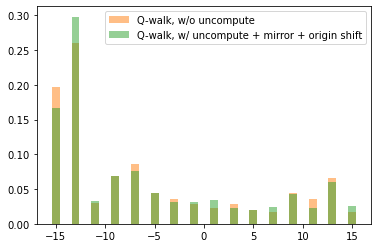

In [20]:
f,ax=plt.subplots()
# classicalWalk(ax,steps=22,color='C0',alpha=0.2,label = 'Classical walk')

qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.h(QrC[0])
    flipReg()
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
jobplot(jobNorm(job)[1],ax,color='C1',alpha=0.5,label = 'Q-walk, w/o uncompute')


qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.h(QrC[0])
    flipReg()
    qc.x(QrC[0])
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
xlst,ylst = [],[]
for i in jobNorm(job)[1]:
    val = int(i,2)
    if val>=2**(Re-1)+2 :
        xlst += [(val-2**Re+1)-2]
    else:
        xlst += [(val+1)-2]
    ylst +=[jobNorm(job)[1][i]]  
ax.bar(xlst,ylst,color='C2',alpha=0.5,label = 'Q-walk, w/ uncompute + mirror + origin shift')
ax.legend()

### Run the Y-gate (phase balancing) coin

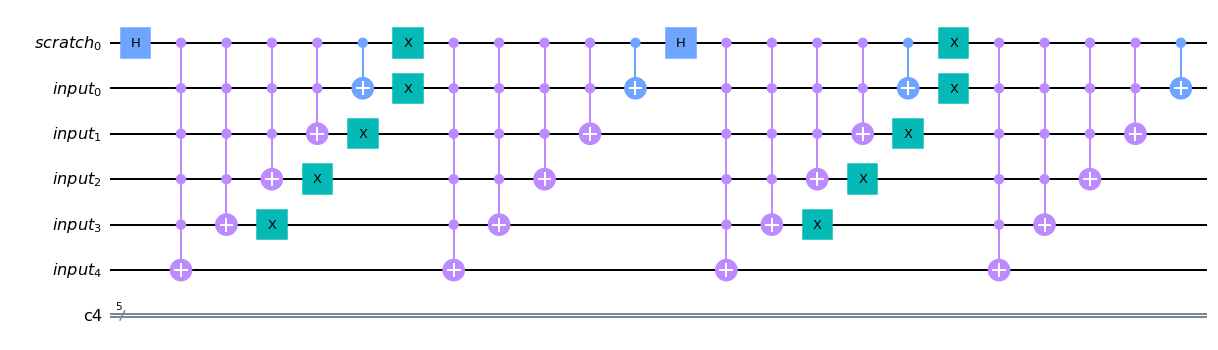

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The QuantumCircuit.u2 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You can use the general 1-qubit gate QuantumCircuit.u instead: u2(φ,λ) = u(π/2, φ, λ). Alternatively, you can decompose it interms of QuantumCircuit.p and QuantumCircuit.sx: u2(φ,λ) = p(π/2+φ) sx p(π/2+λ) (1 pulse on hardware).


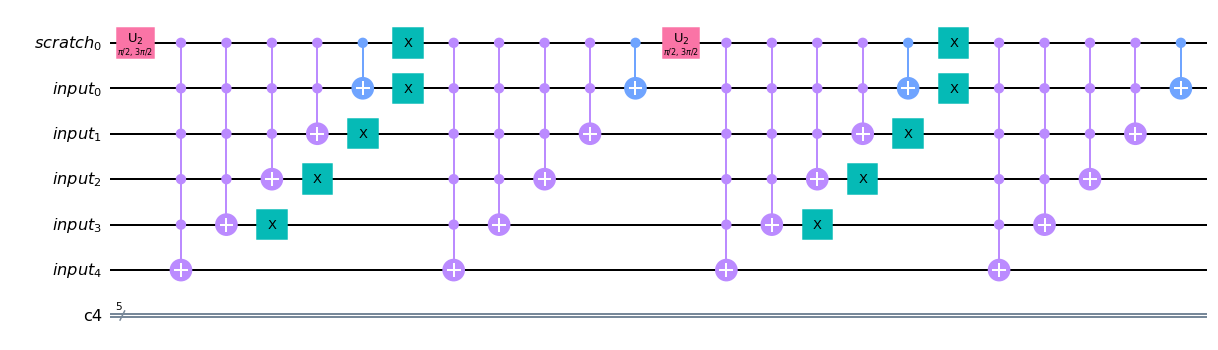

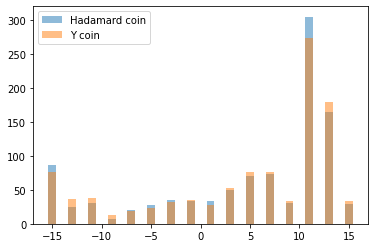

In [19]:
f,ax=plt.subplots()


qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.h(QrC[0])
    flipReg1()
    if i==1:
        display(qc.draw(output='mpl'))
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
jobplot(job,ax, color='C0',alpha=0.5,label = 'Hadamard coin')

ax.legend()


qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.u2(phi=np.pi/2, lam=3*np.pi/2, qubit=QrC[0])
    flipReg1()
    if i==1:
        display(qc.draw(output='mpl'))
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
jobplot(job,ax, color='C1',alpha=0.5,label = 'Y coin')

ax.legend()

### Making gif

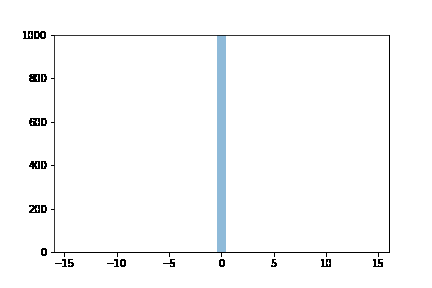

In [21]:
display(Image.open("./images/mygif.gif"))

<ipython-input-24-b6577a3f5855>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots()


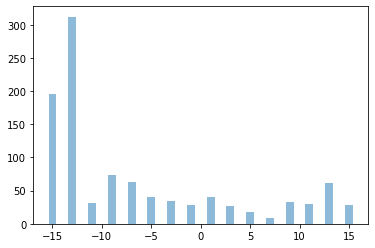

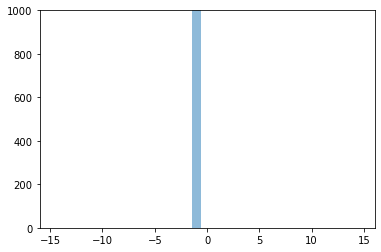

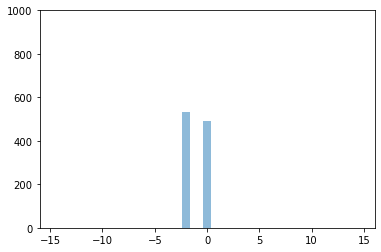

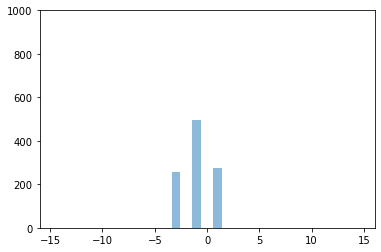

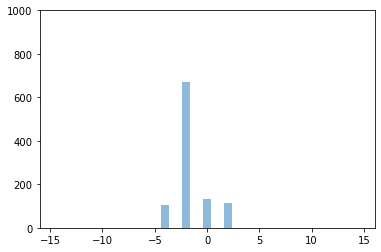

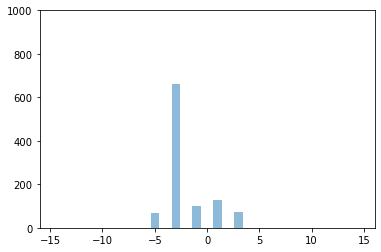

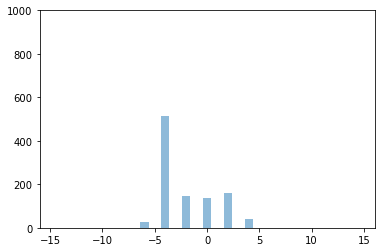

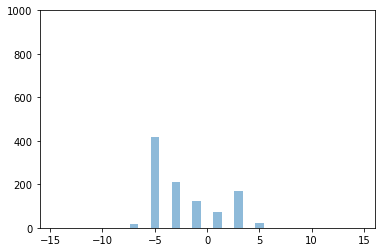

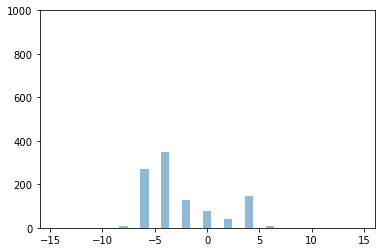

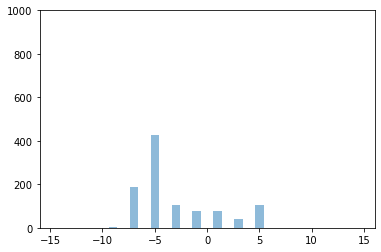

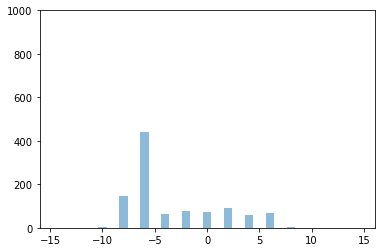

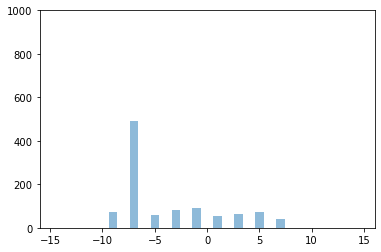

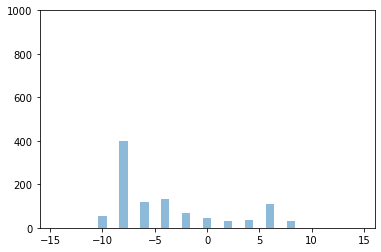

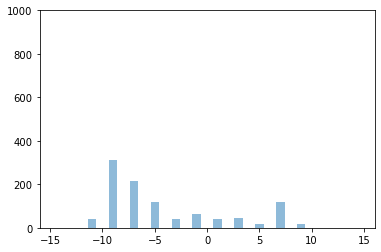

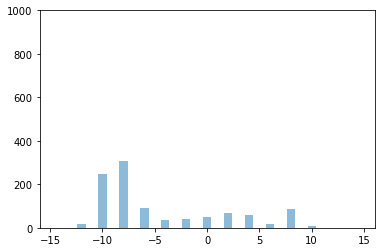

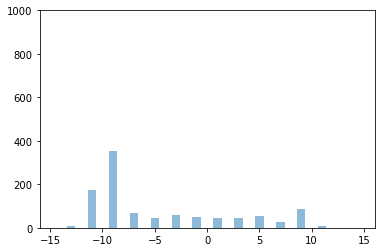

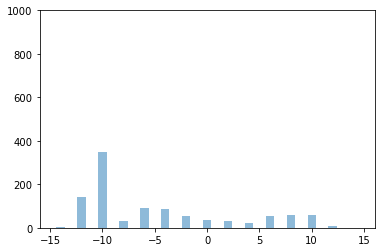

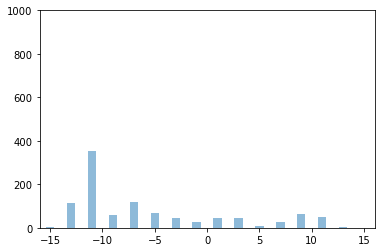

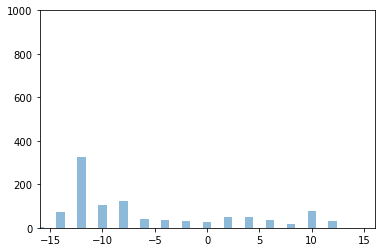

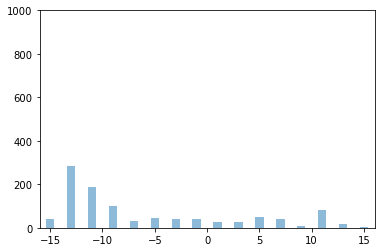

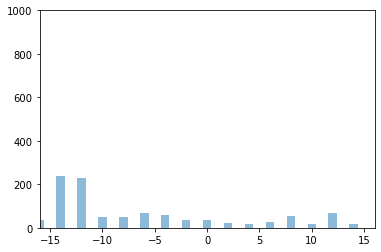

In [24]:
f,ax=plt.subplots()

qc = QuantumCircuit(QrC,QrR,Cr)
for i in range(20):
    qc.h(QrC[0])
    flipReg()
#     if i==1:
#         display(qc.draw(output='mpl'))
qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
jobplot(job,ax,alpha=0.5,label = 'H')

steps = 20
for j in range (steps):
    f,ax=plt.subplots()
    qc = QuantumCircuit(QrC,QrR,Cr)
    for i in range(j):
        qc.h(QrC[0])
        flipReg()
    qc.measure(QrR,Cr)

    job = execute(qc,backend=backend).result().get_counts()
    jobplot(job,ax,alpha=0.5,label = '{}'.format(j))
    ax.set_xlim(-16,16)
    ax.set_ylim(0,1000)
    f.savefig('pic_{}.png'.format(j))
    
filenames = ['pic_'+str(i)+'.png' for i in range(steps)]
with imageio.get_writer('mygif.gif', mode='I', fps = 2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
for filename in set(filenames):
    os.remove(filename)
    
# ax.legend()

### sandbox

In [39]:
def flipReg2():
    qc.cx(QrC[0],QrR[0])
    qc.y(QrR[0])
    qc.ccx(QrC[0],QrR[0],QrR[1])
    qc.y(QrR[1])
    qc.mcx([QrC[0],QrR[0],QrR[1]],QrR[2])
    qc.y(QrR[1])
    qc.ccx(QrC[0],QrR[0],QrR[1])
    qc.y(QrR[0])
    qc.cx(QrC[0],QrR[0])

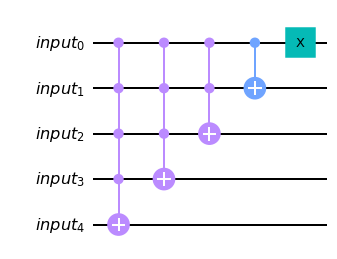

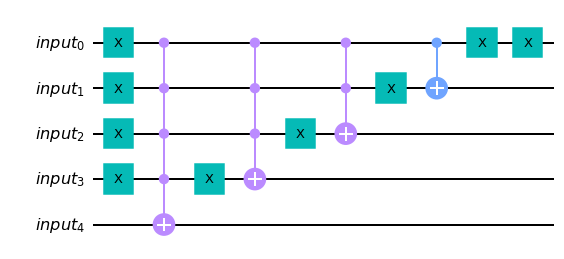

In [53]:
Co = 1
Re = 5*Co
QrR = QuantumRegister(Re, 'input')

# increase block
inqc = QuantumCircuit(QrR)

for i in range(Re-1):
    inqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
inqc.x(0)
display(inqc.draw('mpl'))

ingate = inqc.to_gate()
cingate = ingate.control()

# decrease block
deqc = QuantumCircuit(QrR)

deqc.x(QrR[:Re-1])
for i in range(Re-1):
    deqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
    deqc.x(QrR[Re-1-i-1])
deqc.x(QrR[0])
# deqc.barrier()
display(deqc.draw('mpl'))

degate = deqc.to_gate()
cdegate = degate.control()

In [52]:

circuit = QuantumCircuit(8)
circuit.append(cmygate, [0,2,3,4,5,6])
circuit.draw()

# for i in range(5):
#     qc.h(QrC[0])
#     flipReg2()
# #     qc.x(QrC[0])

#     if i==1:
#         display(qc.draw(output='mpl'))

# qc.measure(QrR,Cr)

# job = execute(qc,backend=backend).result().get_counts()
# # display(plot_histogram(job))
# f,ax=plt.subplots()
# jobplot(job,ax)

q_0: ─────────■─────────
              │         
q_1: ─────────┼─────────
     ┌────────┴────────┐
q_2: ┤0                ├
     │                 │
q_3: ┤1                ├
     │                 │
q_4: ┤2 circuit-138004 ├
     │                 │
q_5: ┤3                ├
     │                 │
q_6: ┤4                ├
     └─────────────────┘
q_7: ───────────────────

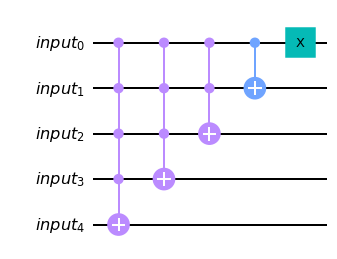

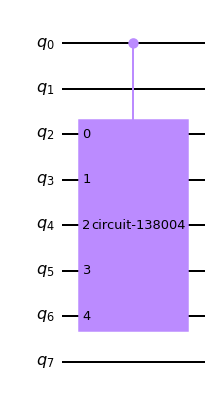

In [45]:
Co = 1
Re = 5*Co

QrC = QuantumRegister(Co, 'scratch')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

myqc = QuantumCircuit(QrR)

for i in range(Re-1):
    myqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
myqc.x(0)
display(myqc.draw('mpl'))

mygate = myqc.to_gate()
cmygate = mygate.control()

circuit = QuantumCircuit(8)
circuit.append(cmygate, [0,2,3,4,5,6])
circuit.draw('mpl')

# for i in range(5):
#     qc.h(QrC[0])
#     flipReg2()
# #     qc.x(QrC[0])

#     if i==1:
#         display(qc.draw(output='mpl'))

# qc.measure(QrR,Cr)

# job = execute(qc,backend=backend).result().get_counts()
# # display(plot_histogram(job))
# f,ax=plt.subplots()
# jobplot(job,ax)

In [46]:
QrC = QuantumRegister(Co, 'scratch')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

backend = BasicAer.get_backend("qasm_simulator")

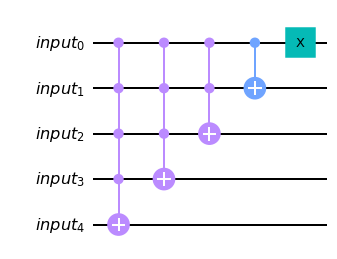

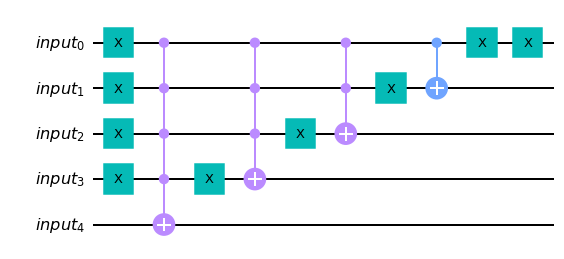

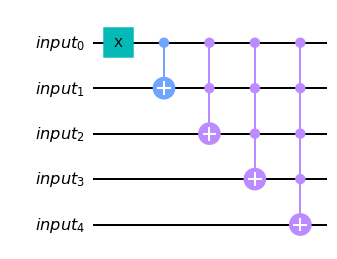

In [47]:
# H-gate ->increase gate -> decrease gate
Co = 1
Re = 5*Co

QrC = QuantumRegister(Co, 'scratch')
QrR = QuantumRegister(Re, 'input')
Cr = ClassicalRegister(Re)

backend = BasicAer.get_backend("qasm_simulator")

# increase block
inqc = QuantumCircuit(QrR)

for i in range(Re-1):
    inqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
inqc.x(0)
display(inqc.draw('mpl'))

ingate = inqc.to_gate()
cingate = ingate.control(label="increase gate")

# decrease block: following paper
deqc = QuantumCircuit(QrR)

deqc.x(QrR[:Re-1])
for i in range(Re-1):
    deqc.mcx(QrR[:Re-1-i],QrR[Re-1-i])
    deqc.x(QrR[Re-1-i-1])
deqc.x(QrR[0])

display(deqc.draw('mpl'))

degate = deqc.to_gate()
cdegate = degate.control(label="decrease gate")


# decrease block2: reversible
deqc2 = QuantumCircuit(QrR)

deqc2.x(0)
for i in range(Re-1,0,-1):
    deqc2.mcx(QrR[:Re-1-(i-1)],QrR[Re-1-(i-1)])

display(deqc2.draw('mpl'))

degate2 = deqc2.to_gate()
cdegate2 = degate2.control(label="decrease gate 2")

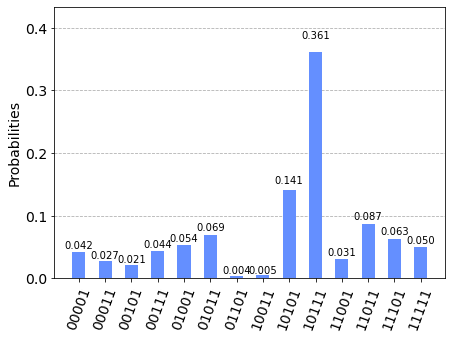

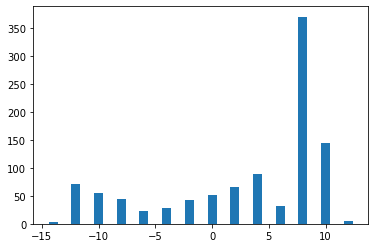

In [65]:
qc = QuantumCircuit(QrC,QrR,Cr)


for i in range(15):
    qc.h(0)
    #qc.u2(np.pi/2,np.pi*3/2, QrC[0])
    qc.append(cingate, [0,1,2,3,4,5])
    #qc.barrier()
    #qc.barrier()
    #qc.u1(np.pi, QrC[0])
    qc.y(QrC[0])
    qc.z(0)
    qc.append(cdegate, [0,1,2,3,4,5])
    qc.y(QrC[0])
    #朝y轉180 
#display(qc.draw())
#     if i==1:
#         display(qc.draw(output='mpl'))

qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
display(plot_histogram(job))
f,ax=plt.subplots()
jobplot(job,ax)

┌───┐┌────────────────┐┌───┐┌──────────────────┐┌───┐»
scratch_0: ┤ X ├┤0               ├┤ X ├┤0                 ├┤ X ├»
           └───┘│                │└───┘│                  │└───┘»
  input_0: ─────┤1               ├─────┤1                 ├─────»
                │                │     │                  │     »
  input_1: ─────┤2               ├─────┤2                 ├─────»
                │  increase gate │     │  decrease gate 2 │     »
  input_2: ─────┤3               ├─────┤3                 ├─────»
                │                │     │                  │     »
  input_3: ─────┤4               ├─────┤4                 ├─────»
                │                │     │                  │     »
  input_4: ─────┤5               ├─────┤5                 ├─────»
                └────────────────┘     └──────────────────┘     »
    c10: 5/═════════════════════════════════════════════════════»
                                                                »
«           ┌────────────────┐┌───┐┌──────────────────┐┌───┐
«scratch_0: ┤0               ├┤ X ├┤0                 ├┤ X ├
«           │                │└───┘│                  │└───┘
«  input_0: ┤1               ├─────┤1                 ├─────
«           │                │     │                  │     
«  input_1: ┤2               ├─────┤2                 ├─────
«           │  increase gate │     │  decrease gate 2 │     
«  input_2: ┤3               ├─────┤3                 ├─────
«           │                │     │                  │     
«  input_3: ┤4               ├─────┤4                 ├─────
«           │                │     │                  │     
«  input_4: ┤5               ├─────┤5                 ├─────
«           └────────────────┘     └──────────────────┘     
«    c10: 5/════════════════════════════════════════════════
«

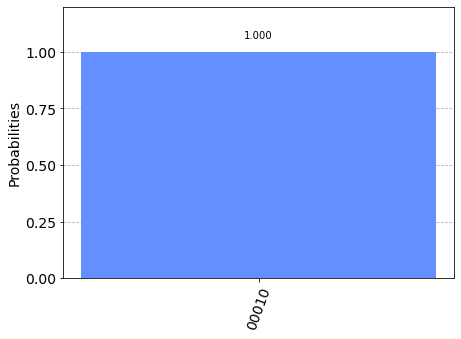

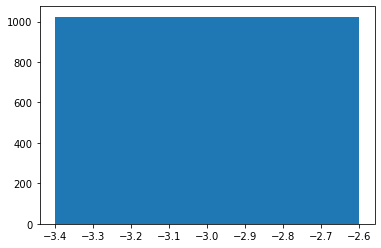

In [48]:
qc = QuantumCircuit(QrC,QrR,Cr)

qc.x(QrC[0])
for i in range(2):
#     qc.h(QrC[0])
    qc.append(cingate, [0,1,2,3,4,5])
    #qc.barrier()
    #qc.barrier()
    qc.x(QrC[0])
    qc.append(cdegate2, [0,1,2,3,4,5])
    qc.x(QrC[0])
    
    
display(qc.draw())
#     if i==1:
#         display(qc.draw(output='mpl'))

qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
display(plot_histogram(job))
f,ax=plt.subplots()
jobplot(job,ax)

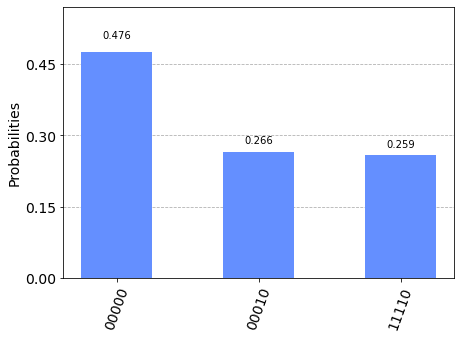

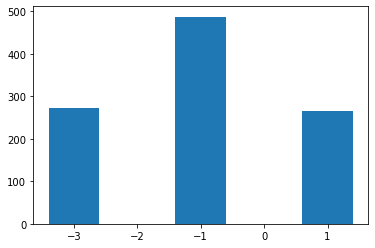

In [100]:
qc = QuantumCircuit(QrC,QrR,Cr)

for i in range(2):
    #qc.h(0)
    qc.u2(np.pi/2,np.pi*3/2, QrC[0])
    qc.append(cingate, [0,1,2,3,4,5])
    #qc.barrier()
    #qc.barrier()
    #qc.u1(np.pi, QrC[0])
    qc.x(QrC[0])
    qc.append(cdegate, [0,1,2,3,4,5])
    qc.x(QrC[0])

    #qc.u1(np.pi/1, QrR[0:6])

    #朝y轉180
    
#display(qc.draw())
#     if i==1:
#         display(qc.draw(output='mpl'))

qc.measure(QrR,Cr)

job = execute(qc,backend=backend).result().get_counts()
display(plot_histogram(job))
f,ax=plt.subplots()
jobplot(job,ax)

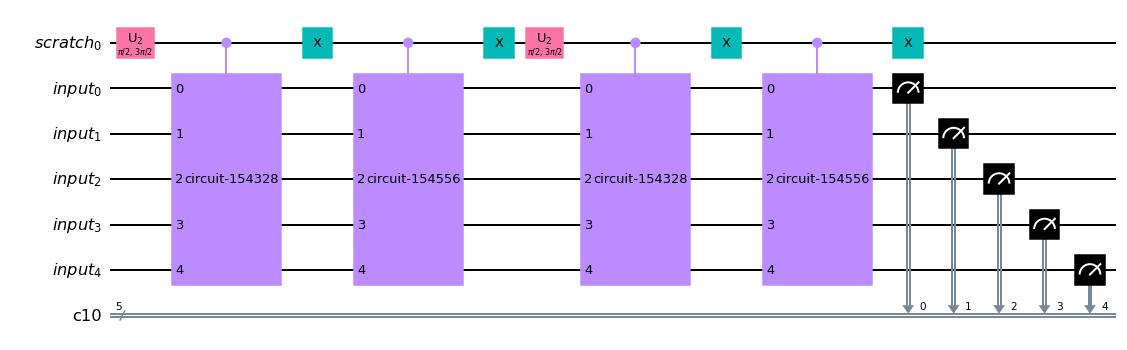

In [101]:
qc.draw('mpl')

# Discussion

What we found is that the modification Y coin operator along did not bring us back the symmetric distribution. We suspect that this is due to the fact that X-flip before used in the DEC gate is also needed to modify to rotate the coin state while preserving the phase symmetry. Further works is an on-going process.

## Future Work and Applications

_Expansion of number of nodes on graph_ 

The walk implemented in this project required 3 qubits for 8 nodes plus an additional 1 qubit for the coin operator. The total time for iterating through coin and shift operator was 16 seconds for 100 flips. 

An example of a real world problem that can be solved using quantum random walks is the mapping of enzymes to understand their evolution when in contact with mutagens. This problem only requires 33 nodes which can be mapped out on 7 qubit circuit. This increase in qubits would increase the total time to 49 seconds for 100 flips. This is a scalable model which can continue to grow to map more complex graphs to problems. 

The time complexity for the quantum simulator approximately follows $({\frac{m+1}{n+1}})^2$ if the number of nodes becomes $2^m$ from $2^n$. This value is based on number of qubits and is roughly estimated. 

#### Expansion for more useful graphs

The cycle graph represents a simple, linear memory architecture (ie. a string). More complicated graph structures, such as binary trees, require higher dimensional "Grover" coins. Such coins are n dimensional bits for graphs of n  The paper [1] presents a generalized form for the grover coin $(G_d)_{i,j}=\frac{2}{d}-\delta_{i,j}$, as well as a circuit for stitched tree of degree 4 that utilizes the Grover coin and the increment and decrement operators we previously defined. A Grover coin of rank $d$ acts on $d-1$ bit state. This efficient implementation will give an exponential speedup for the exponential classical random walk search algorithms.

# Conclusion

In this notebook we showed the basics of Quantum Walk and implementation on Quantum Circuit.
We hope to continue working in this field to showcase further phase inteference by looking into the issue of how to treat phase equally when rotating the coin state before the DEC gate.